### 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression

In [2]:
%matplotlib inline

In [3]:
path = r'/Users/nukisusanti/Documents/GitHub/Road-Crash-Analysis/Road Crash Analysis'

In [4]:
df = pd.read_pickle(os.path.join(path, '01. Data', 'Prepared data', 'road_safety_cleaned.pkl'))

In [5]:
# Command to maximize view of rows and columns

pd.options.display.max_rows = None
pd.options.display.max_columns = len(df.columns)

In [6]:
df.shape

(21242, 37)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21242 entries, 0 to 30404
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Stats Area           21242 non-null  object 
 1   Suburb               21242 non-null  object 
 2   Postcode             21242 non-null  object 
 3   LGA Name             21242 non-null  object 
 4   Total Units          21242 non-null  int64  
 5   Total Cas            21242 non-null  int64  
 6   Total Fats           21242 non-null  int64  
 7   Total SI             21242 non-null  int64  
 8   Total MI             21242 non-null  int64  
 9   Month                21242 non-null  object 
 10  Day                  21242 non-null  object 
 11  Area Speed           21242 non-null  int64  
 12  Position Type        21242 non-null  object 
 13  Horizontal Align     21242 non-null  object 
 14  Vertical Align       21242 non-null  object 
 15  Road Surface         21242 non-null 

#### Pre-Processing

In [8]:
df.drop(columns=['Suburb', 'LGA Name', 'Postcode', 'Total Units', 'Total Cas', 'Total Fats', 'Total SI', 'Total MI', 'Lat', 'Lon'], inplace = True)
#df['Postcode'] = df['Postcode'].astype('int64')

### 2. Accident Severity Analysis

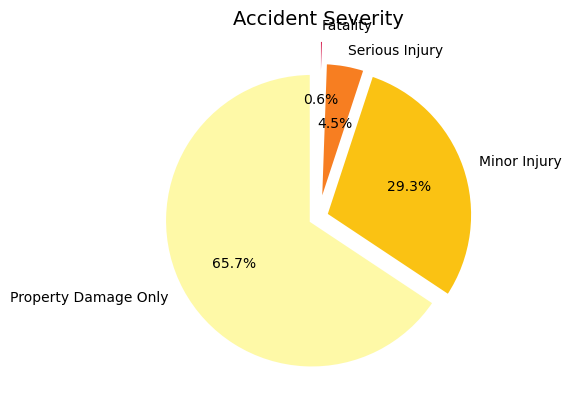

In [9]:
labels = ['Property Damage Only', 'Minor Injury', 'Serious Injury', 'Fatality']
colors = ['#FEF9A7', '#FAC213', '#F77E21', '#D61C4E']

fig, ax = plt.subplots()
myexplode = (0.05, 0.05, 0.05, 0.2)

ax.pie(df['Target'].value_counts(), explode = myexplode, labels = labels,autopct='%1.1f%%', 
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, startangle = 90, colors = colors)

ax.set_title('Accident Severity', fontsize = 14)
plt.show()

In [10]:
# Function for drawing countplot

def countplot(x):
    plt.figure(figsize = (4, 6))
    sns.countplot(data = df, x = x, palette = 'mako_r', 
                  order = df[x].value_counts().index)

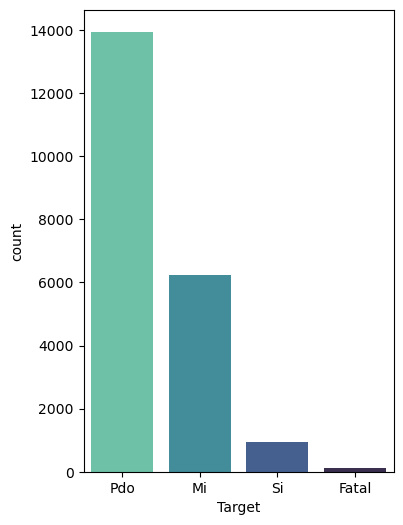

In [11]:
countplot('Target')

#### As we can see, there are 4 classes of severity. We can see that the distribution of the classes is greatly disbalanced. 'Property Damage Only (PDO)' class is in majority while 'Fatality (Fatal)' class is the minority here.
#### Due to imbalance dataset, binary classification will be performed. For this purpose, classes of Mi, Si and Fatal will be grouped together as Injury/Death.

In [12]:
# Grouping Minor injury, Serious injury abd fatality into one class

df.loc[df['Target'] == 'Mi', 'Target'] = 'Injury/Death'
df.loc[df['Target'] == 'Si', 'Target'] = 'Injury/Death'
df.loc[df['Target'] == 'Fatal', 'Target'] = 'Injury/Death'
df.loc[df['Target'] == 'Pdo', 'Target'] = 'PDO'

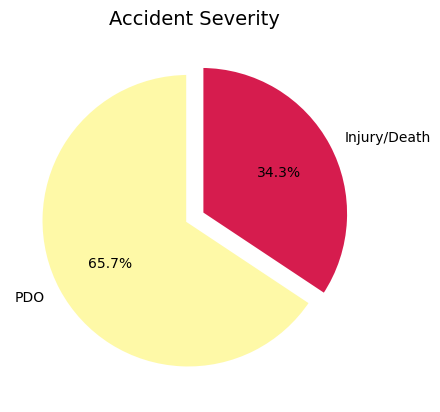

In [13]:
labels = ['PDO', 'Injury/Death']
colors = ['#FEF9A7', '#D61C4E']

fig, ax = plt.subplots()
myexplode = (0.05, 0.05)

ax.pie(df['Target'].value_counts(), explode = myexplode, labels = labels,autopct='%1.1f%%', 
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, startangle = 90, colors = colors)

ax.set_title('Accident Severity', fontsize = 14)
plt.show()

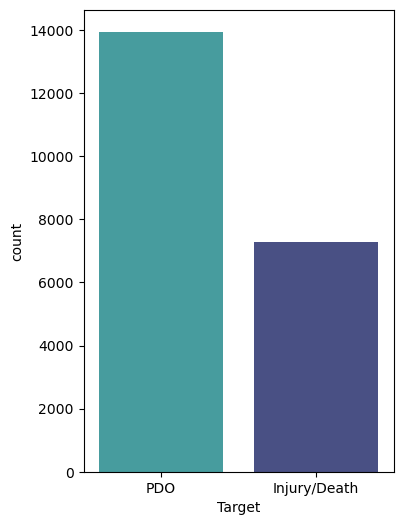

In [14]:
countplot('Target')

In [15]:
df.describe()

,Area Speed,DUI Involved,Drugs Involved,Veh Year,Age,Hourly,Distance To CC
count,21242.000000,21242.000000,21242.000000,21242.000000,21242.000000,21242.000000,21242.000000
mean,63.555927,0.027916,0.021608,2009.775162,40.619857,13.377883,32.143862
std,15.284718,0.164737,0.145404,7.265529,17.588397,4.577779,73.525968
min,10.000000,0.000000,0.000000,1900.000000,3.000000,0.000000,0.050000
25%,60.000000,0.000000,0.000000,2005.000000,26.000000,10.000000,5.830000
50%,60.000000,0.000000,0.000000,2010.000000,37.000000,14.000000,10.730000
75%,60.000000,0.000000,0.000000,2015.000000,53.000000,17.000000,23.980000
max,110.000000,1.000000,1.000000,2021.000000,98.000000,23.000000,1102.270000


In [17]:
# There is outliers in Vehicle Year column: 1900 will be removed

df = df.loc[df['Veh Year'] >= 1940]

### 3. Label-Encoding for Binary Features

In [18]:
labelencoder = LabelEncoder()

In [19]:
df['Target'] = labelencoder.fit_transform(df['Target']) # Target column
df['Target'] = df['Target'].astype('int64')

dict(zip(labelencoder.inverse_transform([0,1]),[0,1]))

{'Injury/Death': 0, 'PDO': 1}

In [20]:
df['DayNight'] = labelencoder.fit_transform(df['DayNight']) 
df['DayNight'] = df['DayNight'].astype('int64')

dict(zip(labelencoder.inverse_transform([0,1]),[0,1]))

{'Daylight': 0, 'Night': 1}

In [21]:
df['Road Surface'] = labelencoder.fit_transform(df['Road Surface']) 
df['Road Surface'] = df['Road Surface'].astype('int64')

dict(zip(labelencoder.inverse_transform([0,1]),[0,1]))

{'Sealed': 0, 'Unsealed': 1}

In [22]:
df['Moisture Cond'] = labelencoder.fit_transform(df['Moisture Cond']) 
df['Moisture Cond'] = df['Moisture Cond'].astype('int64')

dict(zip(labelencoder.inverse_transform([0,1]),[0,1]))

{'Dry': 0, 'Wet': 1}

In [23]:
df['Weather Cond'] = labelencoder.fit_transform(df['Weather Cond']) 
df['Weather Cond'] = df['Weather Cond'].astype('int64')

dict(zip(labelencoder.inverse_transform([0,1]),[0,1]))

{'Not Raining': 0, 'Raining': 1}

In [24]:
df['Sex'] = labelencoder.fit_transform(df['Sex']) 
df['Sex'] = df['Sex'].astype('int64')

dict(zip(labelencoder.inverse_transform([0,1]),[0,1]))

{'Female': 0, 'Male': 1}

In [25]:
df['Unit Involved'] = labelencoder.fit_transform(df['Unit Involved']) 
df['Unit Involved'] = df['Unit Involved'].astype('int64')

dict(zip(labelencoder.inverse_transform([0,1]),[0,1]))

{'Bicycle/Scooter': 0, 'Motor Vehicle': 1}

In [26]:
df['Day Group'] = labelencoder.fit_transform(df['Day Group']) 
df['Day Group'] = df['Day Group'].astype('int64')

dict(zip(labelencoder.inverse_transform([0,1]),[0,1]))

{'Weekday': 0, 'Weekend': 1}

In [27]:
df.head()

,Stats Area,Month,Day,Area Speed,Position Type,Horizontal Align,Vertical Align,Road Surface,Moisture Cond,Weather Cond,DayNight,Crash Type,Entity Code,Target,Traffic Ctrls,DUI Involved,Drugs Involved,Veh Year,Direction Of Travel,Sex,Age,Unit Involved,Age Group,Hourly,Day Group,Month Group,Distance To CC
0,2 Metropolitan,August,Tuesday,90,Divided Road,Straight Road,Level,0,0,0,0,Side Swipe,Driver Rider,1,No Control,0,0,2016.0,South East,1,60,1,55-64,12,0,Q3,26.69
1,2 Metropolitan,August,Tuesday,90,Divided Road,Straight Road,Level,0,0,0,0,Side Swipe,Driver Rider,1,No Control,0,0,2017.0,South East,1,32,1,25-34,12,0,Q3,26.69
2,2 Metropolitan,January,Wednesday,10,Other,Straight Road,Level,0,0,0,0,Hit Pedestrian,Pedestrian,0,No Control,0,0,2015.0,East,0,34,1,25-34,11,0,Q1,6.45
4,2 Metropolitan,January,Wednesday,60,Cross Road,Straight Road,Level,0,1,1,0,Hit Fixed Object,Driver Rider,1,Roundabout,0,0,2006.0,North East,0,19,1,15-24,11,0,Q1,14.13
6,2 Metropolitan,January,Friday,60,T-Junction,Straight Road,Level,0,0,0,1,Hit Fixed Object,Driver Rider,1,No Control,1,0,2006.0,North East,1,33,1,25-34,1,0,Q1,5.16


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21234 entries, 0 to 30404
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Stats Area           21234 non-null  object 
 1   Month                21234 non-null  object 
 2   Day                  21234 non-null  object 
 3   Area Speed           21234 non-null  int64  
 4   Position Type        21234 non-null  object 
 5   Horizontal Align     21234 non-null  object 
 6   Vertical Align       21234 non-null  object 
 7   Road Surface         21234 non-null  int64  
 8   Moisture Cond        21234 non-null  int64  
 9   Weather Cond         21234 non-null  int64  
 10  DayNight             21234 non-null  int64  
 11  Crash Type           21234 non-null  object 
 12  Entity Code          21234 non-null  object 
 13  Target               21234 non-null  int64  
 14  Traffic Ctrls        21234 non-null  object 
 15  DUI Involved         21234 non-null 

### 4. One-Hot-Encoding for categorical data
#### As many of the features are categorical, One-Hot-Encoding is performed.

In [29]:
# Creating categorical features list

catvar = df.select_dtypes(include = ['object']).columns
catvar

Index(['Stats Area', 'Month', 'Day', 'Position Type', 'Horizontal Align',
       'Vertical Align', 'Crash Type', 'Entity Code', 'Traffic Ctrls',
       'Direction Of Travel', 'Age Group', 'Month Group'],
      dtype='object')

In [30]:
for i in df:
    if i in catvar:
        print(df[i].unique())

['2 Metropolitan' '3 Country' '1 City']
['August' 'January' 'February' 'March' 'April' 'May' 'June' 'July'
 'September' 'October' 'November' 'December']
['Tuesday' 'Wednesday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Thursday']
['Divided Road' 'Other' 'Cross Road' 'T-Junction' 'Not Divided' 'Multiple'
 'Freeway' 'Ramp Off' 'Ramp On' 'Y-Junction' 'One Way' 'Interchange'
 'Pedestrian Crossing' 'Rail Crossing' 'Rail Xing' 'Crossover']
['Straight Road' 'Curved, View Open' 'Curved, View Obscured']
['Level' 'Slope' 'Bottom Of Hill' 'Crest Of Hill']
['Side Swipe' 'Hit Pedestrian' 'Hit Fixed Object' 'Head On' 'Right Angle'
 'Roll Over' 'Rear End' 'Right Turn' 'Left Road - Out Of Control' 'Other'
 'Hit Parked Vehicle' 'Hit Object On Road' 'Hit Animal']
['Driver Rider' 'Pedestrian' 'Other' 'Passenger' 'Animal']
['No Control' 'Roundabout' 'Traffic Signals' 'Stop Sign' 'Give Way Sign'
 'Other' 'Rail Xing - Flashing' 'Rail Xing - Boom'
 'Rail Xing - No Control' 'Rail Xing-Traffic Signals']
['South Ea

In [31]:
# Creating one hot encoder object 

onehotencoder = OneHotEncoder(handle_unknown = 'ignore') # Whether to raise an error

In [32]:
# Fit and transform the data using the .fit_transform() method
# return the array version of the transformed data using the .toarray() method

df_enc = onehotencoder.fit_transform(df[catvar]).toarray()
df_enc

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [33]:
feature_array = onehotencoder.get_feature_names_out()
feature_array

array(['Stats Area_1 City', 'Stats Area_2 Metropolitan',
       'Stats Area_3 Country', 'Month_April', 'Month_August',
       'Month_December', 'Month_February', 'Month_January', 'Month_July',
       'Month_June', 'Month_March', 'Month_May', 'Month_November',
       'Month_October', 'Month_September', 'Day_Friday', 'Day_Monday',
       'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday',
       'Day_Wednesday', 'Position Type_Cross Road',
       'Position Type_Crossover', 'Position Type_Divided Road',
       'Position Type_Freeway', 'Position Type_Interchange',
       'Position Type_Multiple', 'Position Type_Not Divided',
       'Position Type_One Way', 'Position Type_Other',
       'Position Type_Pedestrian Crossing', 'Position Type_Rail Crossing',
       'Position Type_Rail Xing', 'Position Type_Ramp Off',
       'Position Type_Ramp On', 'Position Type_T-Junction',
       'Position Type_Y-Junction',
       'Horizontal Align_Curved, View Obscured',
       'Horizontal Align_Cur

In [34]:
# Convert to dataframe

df_enc = pd.DataFrame(df_enc, columns = feature_array)
df_enc.head()

,Stats Area_1 City,Stats Area_2 Metropolitan,Stats Area_3 Country,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Day_Friday,Day_Monday,Day_Saturday,...,Direction Of Travel_South,Direction Of Travel_South East,Direction Of Travel_South West,Direction Of Travel_West,Age Group_0-4,Age Group_15-24,Age Group_25-34,Age Group_35-44,Age Group_45-54,Age Group_5-14,Age Group_55-64,Age Group_65-74,Age Group_75-84,Age Group_85-94,Age Group_95-104,Month Group_Q1,Month Group_Q2,Month Group_Q3
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
df_enc.shape

(21234, 95)

In [36]:
# Concatenate with the dataframe

df_num = df.drop(columns = catvar, axis = 1).reset_index()
df_num = df_num.drop(columns = 'index', axis = 1)
df_num.shape

(21234, 15)

In [37]:
df_new = pd.concat([df_num, df_enc], axis=1)
df_new.shape

(21234, 110)

In [38]:
df_new.head()

,Area Speed,Road Surface,Moisture Cond,Weather Cond,DayNight,Target,DUI Involved,Drugs Involved,Veh Year,Sex,Age,Unit Involved,Hourly,Day Group,Distance To CC,Stats Area_1 City,Stats Area_2 Metropolitan,Stats Area_3 Country,...,Direction Of Travel_South,Direction Of Travel_South East,Direction Of Travel_South West,Direction Of Travel_West,Age Group_0-4,Age Group_15-24,Age Group_25-34,Age Group_35-44,Age Group_45-54,Age Group_5-14,Age Group_55-64,Age Group_65-74,Age Group_75-84,Age Group_85-94,Age Group_95-104,Month Group_Q1,Month Group_Q2,Month Group_Q3
0,90,0,0,0,0,1,0,0,2016.0,1,60,1,12,0,26.69,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,90,0,0,0,0,1,0,0,2017.0,1,32,1,12,0,26.69,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,10,0,0,0,0,0,0,0,2015.0,0,34,1,11,0,6.45,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,60,0,1,1,0,1,0,0,2006.0,0,19,1,11,0,14.13,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,60,0,0,0,1,1,1,0,2006.0,1,33,1,1,0,5.16,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 5. Preparing and Splitting Dataset

In [39]:
X = df_new.drop(columns = 'Target') # Features
y = df_new['Target'] # Dependent variable (Target)

### 6. Features Selection Embedded Method

In [40]:
reg = LassoCV()
reg.fit(X, y)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.000819
Best score using built-in LassoCV: 0.067538


In [41]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 45 variables and eliminated the other 64 variables


In [42]:
imp_coef = coef.sort_values()
imp_coef

Drugs Involved                            -0.459470
Crash Type_Hit Pedestrian                 -0.286269
Crash Type_Head On                        -0.156022
Crash Type_Roll Over                      -0.144162
DUI Involved                              -0.088774
Crash Type_Right Turn                     -0.062480
Crash Type_Rear End                       -0.028928
Month_February                            -0.028775
Day Group                                 -0.021312
Month_March                               -0.016244
Direction Of Travel_East                  -0.012857
Direction Of Travel_North East            -0.008607
Month_August                              -0.007983
Position Type_Cross Road                  -0.006983
Day_Sunday                                -0.005529
Day_Tuesday                               -0.005458
Month Group_Q1                            -0.005103
Vertical Align_Slope                      -0.004364
Age Group_15-24                           -0.003386
Area Speed  

In [43]:
selected_features = imp_coef.loc[(imp_coef != 0) | (imp_coef != -0)]
selected_features 

Drugs Involved                       -0.459470
Crash Type_Hit Pedestrian            -0.286269
Crash Type_Head On                   -0.156022
Crash Type_Roll Over                 -0.144162
DUI Involved                         -0.088774
Crash Type_Right Turn                -0.062480
Crash Type_Rear End                  -0.028928
Month_February                       -0.028775
Day Group                            -0.021312
Month_March                          -0.016244
Direction Of Travel_East             -0.012857
Direction Of Travel_North East       -0.008607
Month_August                         -0.007983
Position Type_Cross Road             -0.006983
Day_Sunday                           -0.005529
Day_Tuesday                          -0.005458
Month Group_Q1                       -0.005103
Vertical Align_Slope                 -0.004364
Age Group_15-24                      -0.003386
Area Speed                           -0.002137
Age                                  -0.001120
Horizontal Al

Text(0.5, 1.0, 'Feature importance using Lasso Model')

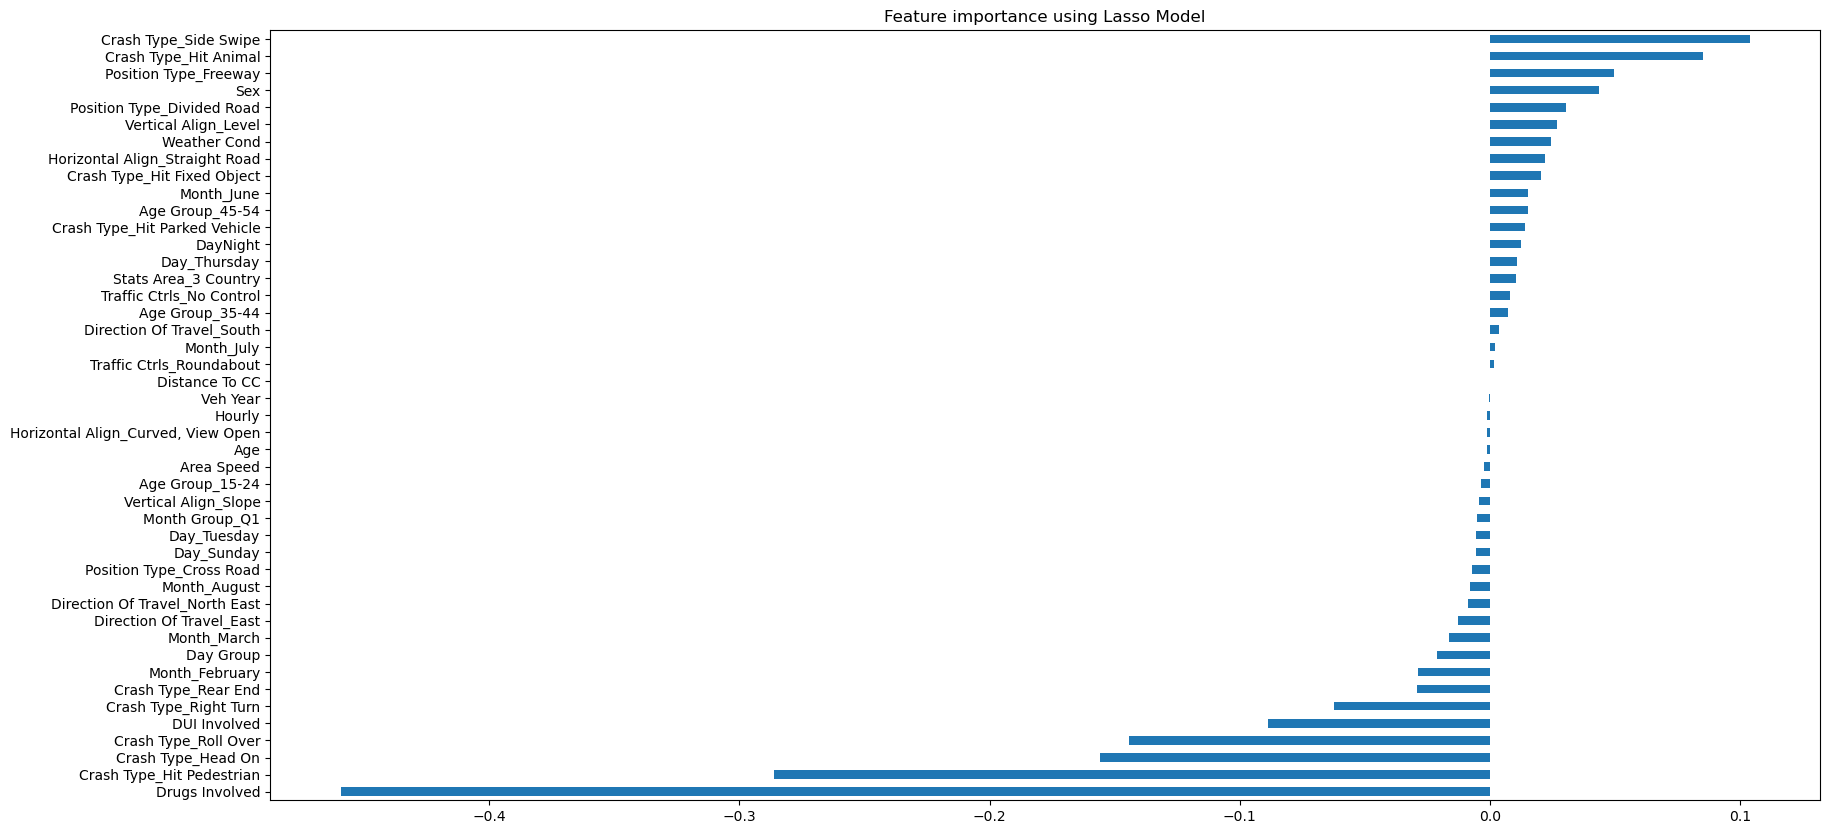

In [44]:
plt.rcParams['figure.figsize'] = (20, 10)
selected_features.plot(kind = 'barh')
plt.title('Feature importance using Lasso Model')

### 7. Building Models

In [45]:
# Divide into training-set and test-set: 70% 30% ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [46]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14863, 109) (6371, 109) (14863,) (6371,)


In [64]:
features = X_test.columns
features

Index(['Area Speed', 'Road Surface', 'Moisture Cond', 'Weather Cond',
       'DayNight', 'DUI Involved', 'Drugs Involved', 'Veh Year', 'Sex', 'Age',
       ...
       'Age Group_45-54', 'Age Group_5-14', 'Age Group_55-64',
       'Age Group_65-74', 'Age Group_75-84', 'Age Group_85-94',
       'Age Group_95-104', 'Month Group_Q1', 'Month Group_Q2',
       'Month Group_Q3'],
      dtype='object', length=109)

### A. Logistic Regression

In [49]:
lgr = LogisticRegression(max_iter=3000)

In [50]:
lgr.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [51]:
y_pred_lgr = lgr.predict(X_test)

In [52]:
print(accuracy_score(y_test, y_pred_lgr))

0.6755611363993094


In [53]:
cf_matrix_lgr = confusion_matrix(y_test, y_pred_lgr)

In [54]:
TN, FP, FN, TP = cf_matrix_lgr.ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  3978
False Positive(FP) =  1861
True Negative(TN)  =  326
False Negative(FN) =  206


<Axes: >

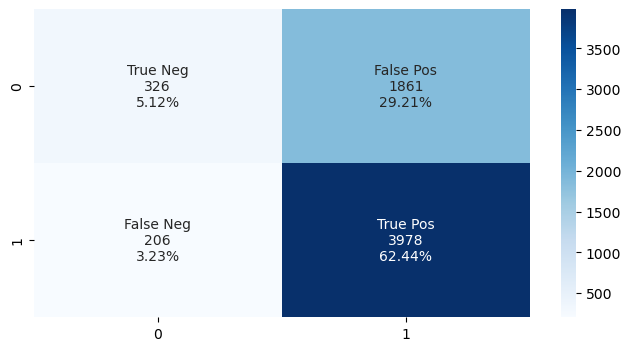

In [55]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_lgr.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_lgr.flatten()/np.sum(cf_matrix_lgr)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,4))
sns.heatmap(cf_matrix_lgr, annot=labels, fmt='', cmap='Blues')

In [56]:
logres_result = pd.DataFrame(lgr.coef_, columns=X_test.columns, index=['Coef']).T.sort_values(by='Coef', key=abs)

In [57]:
logres_nonzero = logres_result.loc[(logres_result['Coef'] != 0) | (logres_result['Coef'] != -0)]
logres_nonzero.sort_values(by='Coef', ascending=False, key=abs)

,Coef
Drugs Involved,-1.990355
Crash Type_Side Swipe,1.035797
Crash Type_Hit Pedestrian,-0.925976
Crash Type_Roll Over,-0.721064
DUI Involved,-0.715499
Crash Type_Head On,-0.649857
Entity Code_Pedestrian,-0.425291
Position Type_Freeway,0.387244
Crash Type_Hit Animal,0.377271
Entity Code_Animal,0.377271


Text(0.5, 1.0, 'Feature importance using Logistic Regression')

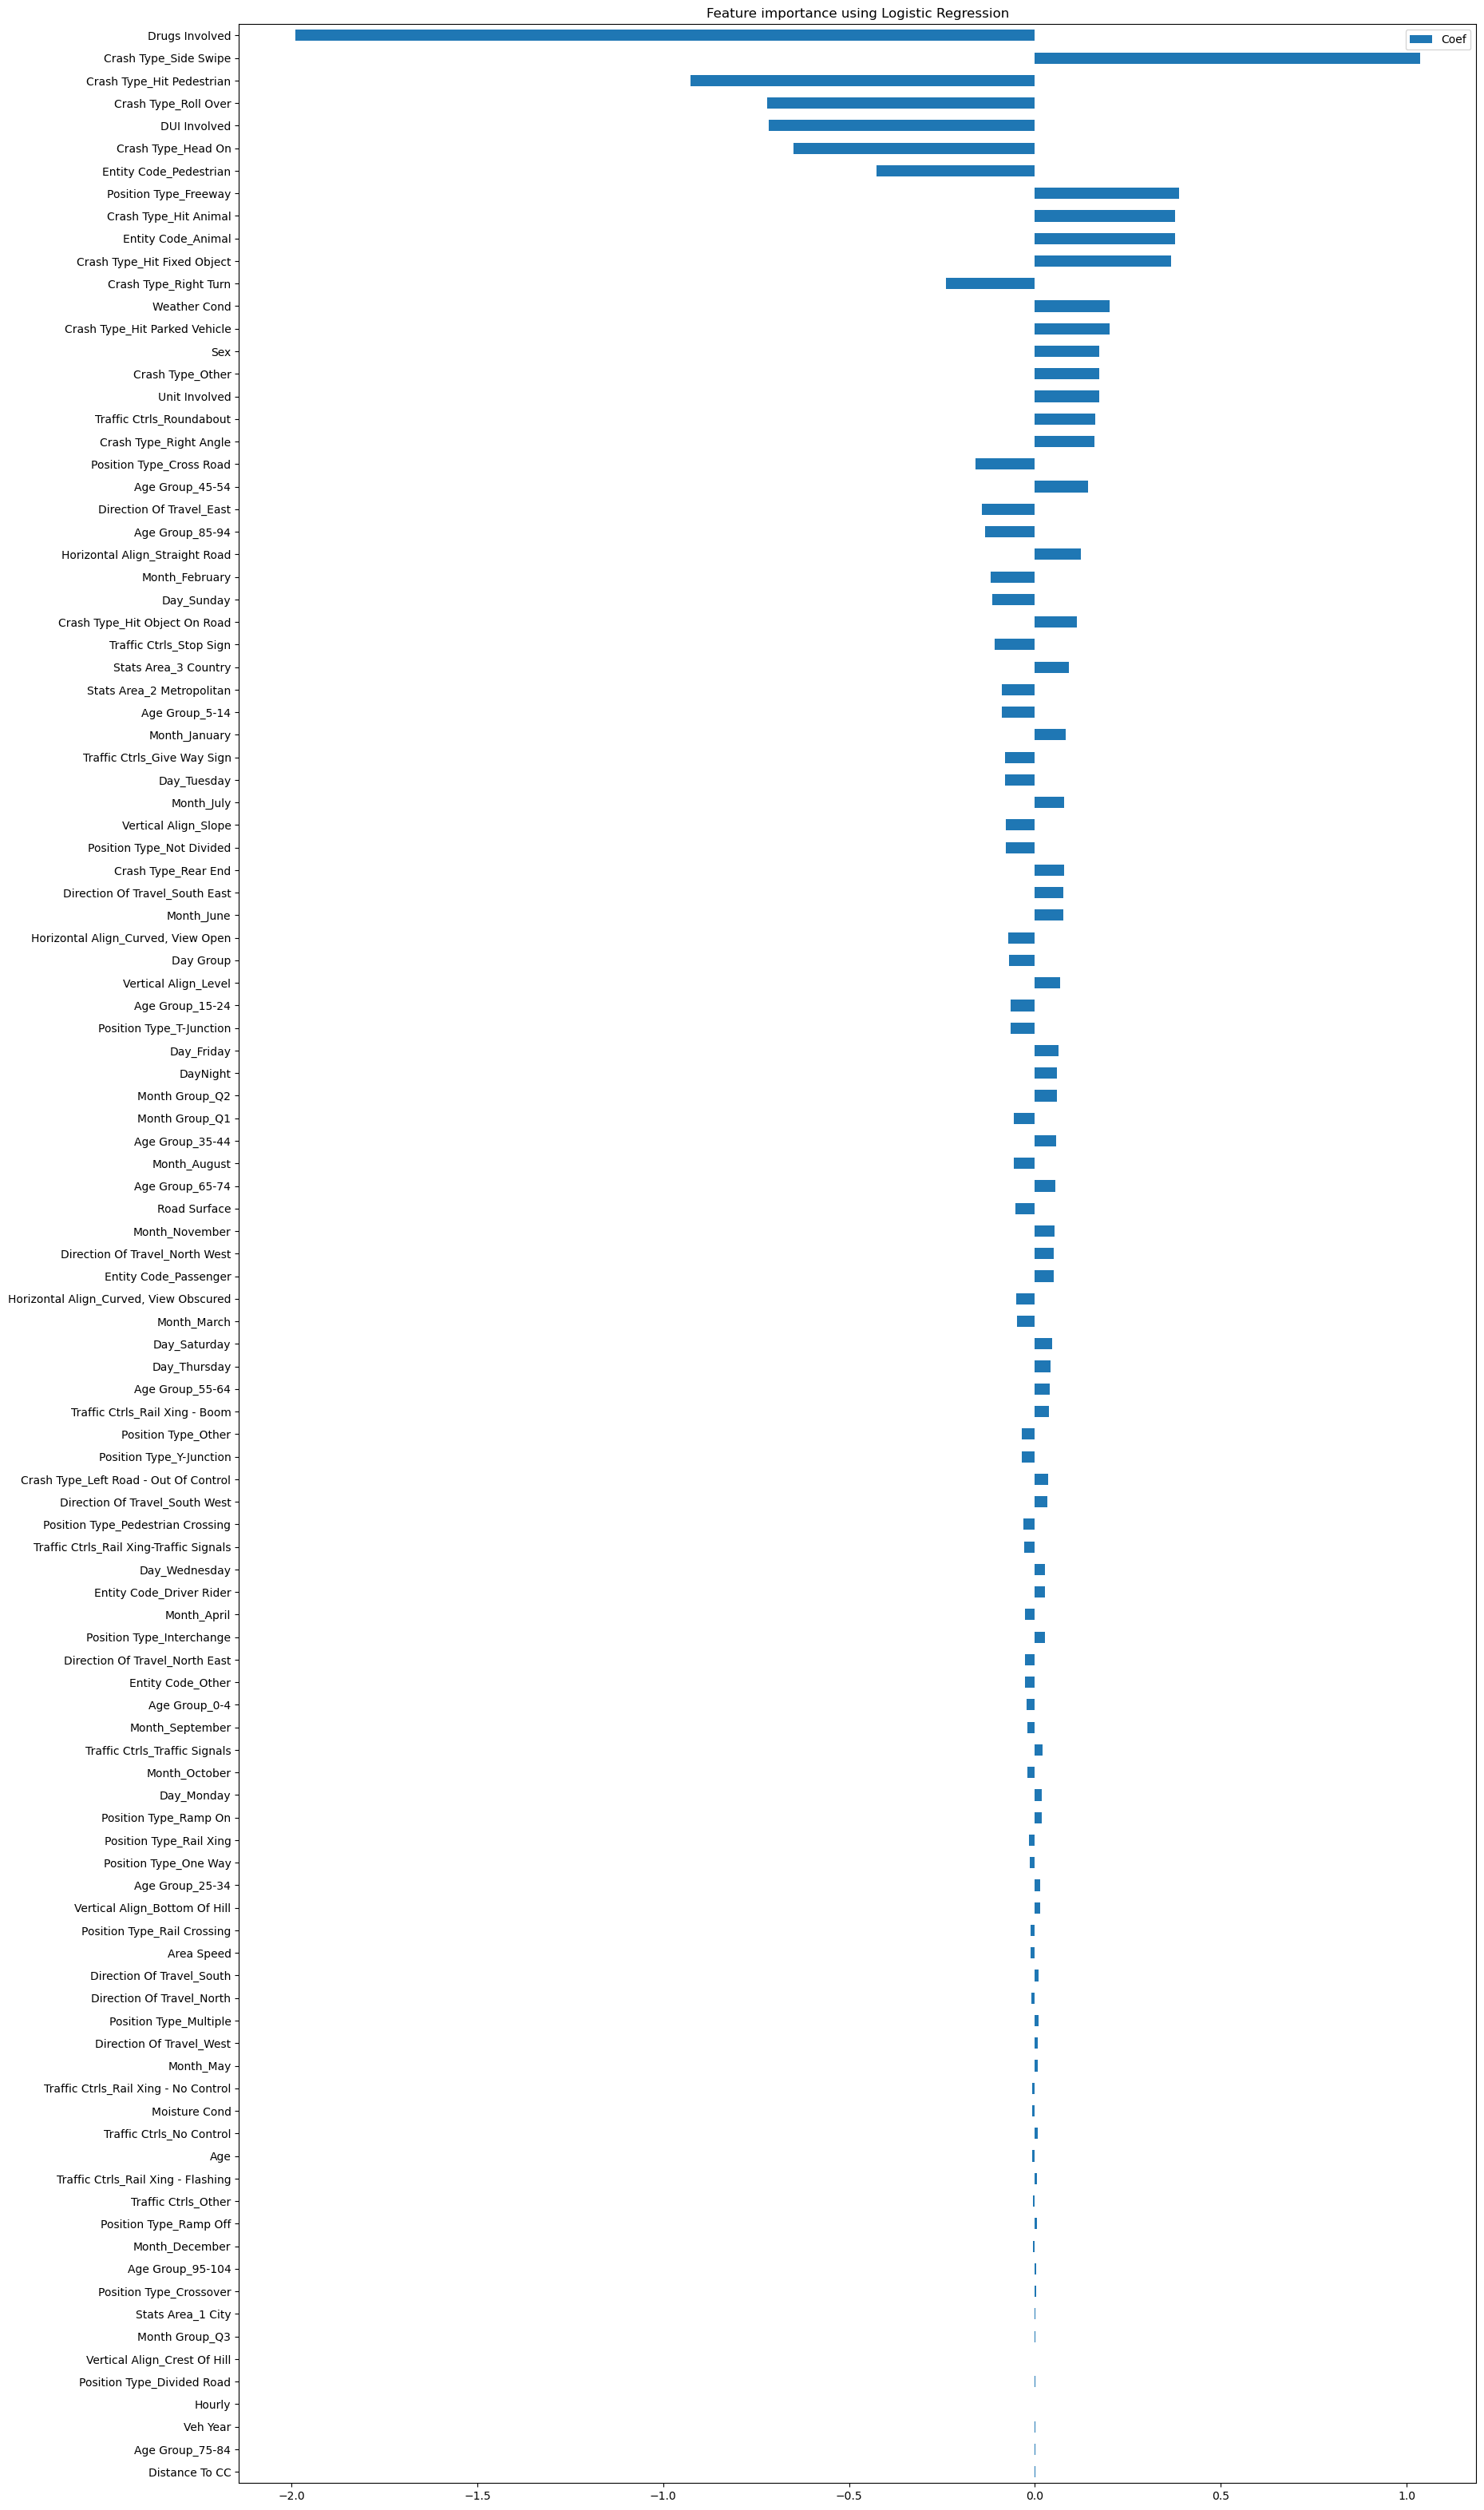

In [58]:
plt.rcParams['figure.figsize'] = (20, 40)
logres_nonzero.plot(kind = 'barh')
plt.title('Feature importance using Logistic Regression')

### B. Decision Tree Classifier Model - Entropy
#### A Decision Tree is a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules (if-else) inferred from the data features.

In [59]:
# Create a Decision Tree object.

dtc = DecisionTreeClassifier(criterion = 'entropy')

In [60]:
# Fit the DTC object onto the training set.

dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [65]:
y_pred_dtc = dtc.predict(X_test)

In [67]:
print('Test Accuracy:', accuracy_score(y_test, y_pred_dtc))

Test Accuracy: 0.647935959817925


In [68]:
cf_matrix_dtc = confusion_matrix(y_test, y_pred_dtc)

In [69]:
TN, FP, FN, TP = cf_matrix_dtc.ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  3034
False Positive(FP) =  1093
True Negative(TN)  =  1094
False Negative(FN) =  1150


<Axes: >

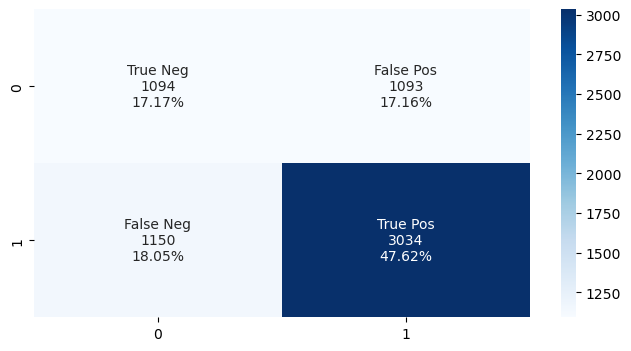

In [70]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_dtc.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_dtc.flatten()/np.sum(cf_matrix_dtc)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,4))
sns.heatmap(cf_matrix_dtc, annot=labels, fmt='', cmap='Blues')

In [71]:
pd.Series(y_pred_dtc).value_counts()

1    4127
0    2244
dtype: int64

In [72]:
pd.Series(y_test).value_counts()

1    4184
0    2187
Name: Target, dtype: int64

In [73]:
# Extracting the importances by sklearn 
importances_dtc = dtc.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_dtc = {}
for i, feature in enumerate(features):
    feature_importance_dtc[feature] = round(importances_dtc[i], 3)

print(f"Feature importance by sklearn: {feature_importance_dtc}")

Feature importance by sklearn: {'Area Speed': 0.019, 'Road Surface': 0.003, 'Moisture Cond': 0.007, 'Weather Cond': 0.006, 'DayNight': 0.01, 'DUI Involved': 0.004, 'Drugs Involved': 0.02, 'Veh Year': 0.092, 'Sex': 0.006, 'Age': 0.092, 'Unit Involved': 0.001, 'Hourly': 0.087, 'Day Group': 0.007, 'Distance To CC': 0.166, 'Stats Area_1 City': 0.001, 'Stats Area_2 Metropolitan': 0.004, 'Stats Area_3 Country': 0.003, 'Month_April': 0.005, 'Month_August': 0.011, 'Month_December': 0.011, 'Month_February': 0.008, 'Month_January': 0.006, 'Month_July': 0.008, 'Month_June': 0.01, 'Month_March': 0.009, 'Month_May': 0.013, 'Month_November': 0.009, 'Month_October': 0.009, 'Month_September': 0.008, 'Day_Friday': 0.012, 'Day_Monday': 0.012, 'Day_Saturday': 0.007, 'Day_Sunday': 0.005, 'Day_Thursday': 0.009, 'Day_Tuesday': 0.011, 'Day_Wednesday': 0.009, 'Position Type_Cross Road': 0.008, 'Position Type_Crossover': 0.0, 'Position Type_Divided Road': 0.012, 'Position Type_Freeway': 0.002, 'Position Type_I

In [74]:
dtc_result = pd.DataFrame({'Feature':feature_importance_dtc.keys(),'Importance':feature_importance_dtc.values()})
dtc_result.set_index('Feature', inplace = True)
dtc_result.sort_values(by='Importance', ascending=False, key=abs)

,Importance
Feature,
Distance To CC,0.166
Veh Year,0.092
Age,0.092
Hourly,0.087
Drugs Involved,0.020
Area Speed,0.019
Month Group_Q1,0.014
Direction Of Travel_West,0.013
Month_May,0.013


In [75]:
dtc_nonzero = dtc_result.loc[(dtc_result['Importance'] != 0) | (dtc_result['Importance'] != -0)]
dtc_nonzero = dtc_nonzero.sort_values(by='Importance', key=abs)
dtc_nonzero

,Importance
Feature,
Crash Type_Hit Object On Road,0.001
Crash Type_Hit Animal,0.001
Vertical Align_Bottom Of Hill,0.001
Position Type_Pedestrian Crossing,0.001
Position Type_Multiple,0.001
Unit Involved,0.001
Crash Type_Left Road - Out Of Control,0.001
Crash Type_Other,0.001
Entity Code_Driver Rider,0.001


Text(0.5, 1.0, 'Feature importance using Decision Tree')

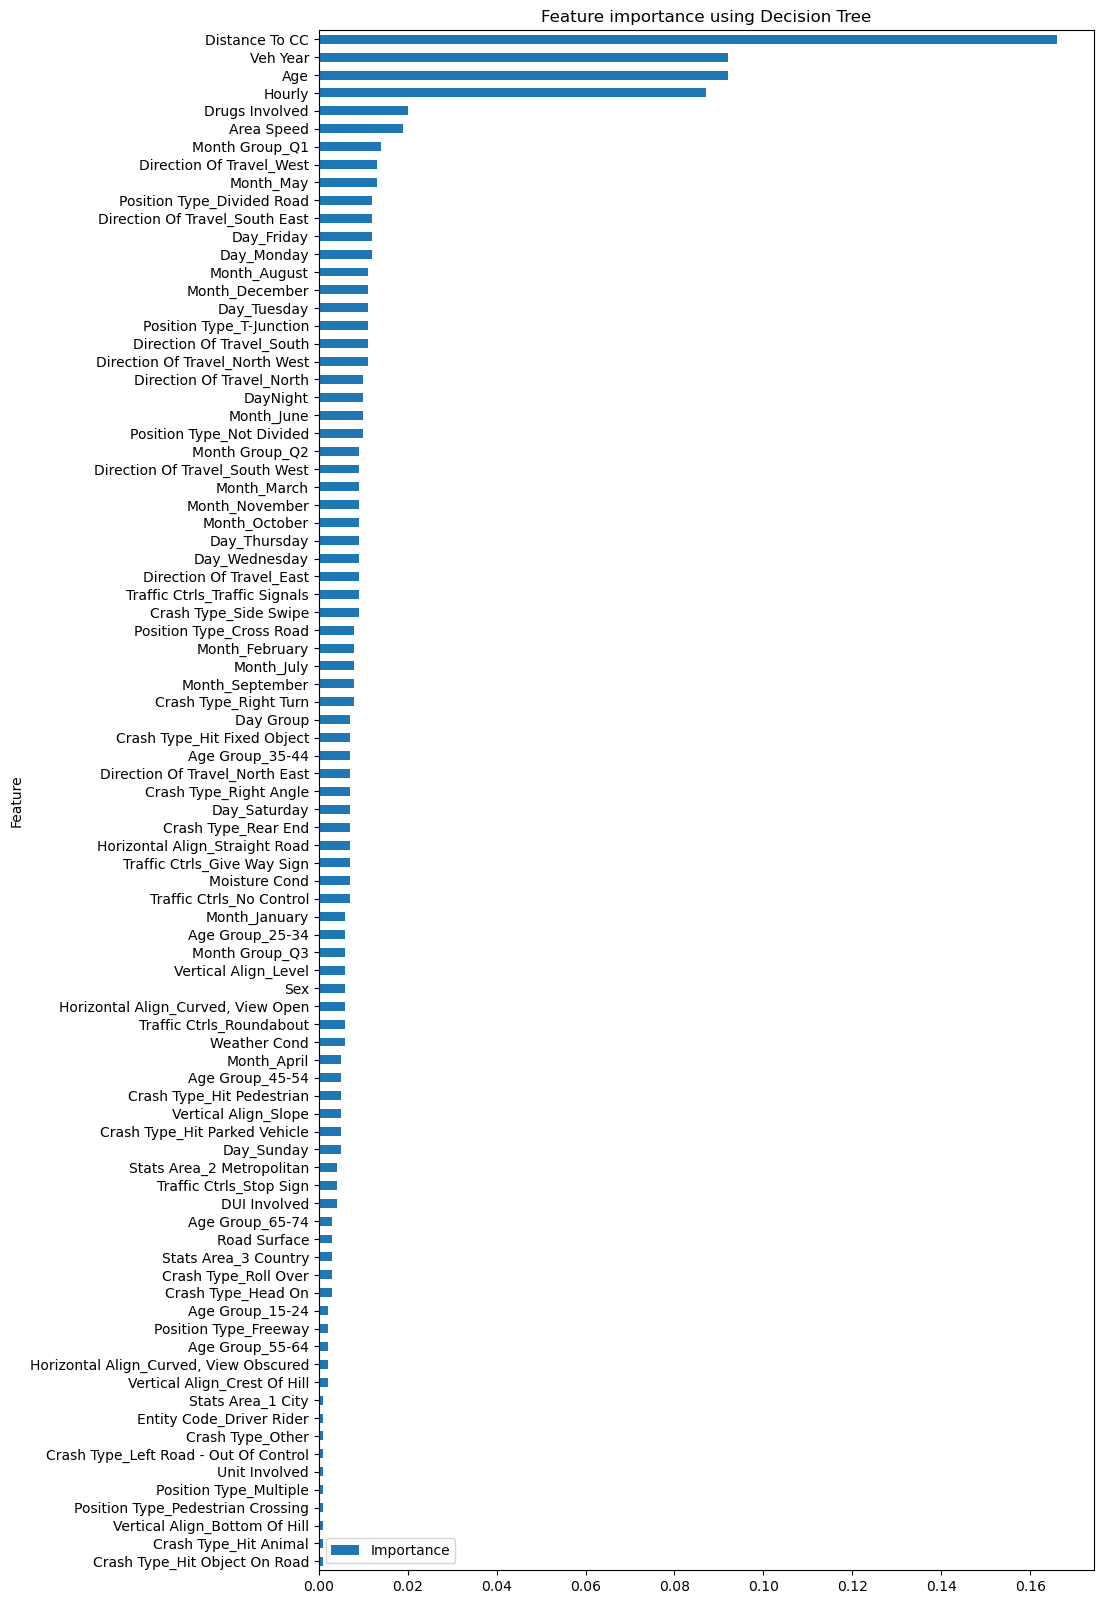

In [76]:
plt.rcParams['figure.figsize'] = (10, 20)
dtc_nonzero.plot(kind = 'barh')
plt.title('Feature importance using Decision Tree')

### C. Random Forest

In [77]:
# Create a RF object.

rfc = RandomForestClassifier()

In [78]:
# Fit the DTC object onto the training set.

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [79]:
y_pred_rfc = rfc.predict(X_test)

In [80]:
print('Train Accuracy:', accuracy_score(y_train, rfc.predict(X_train)))

Train Accuracy: 1.0


In [81]:
print('Test Accuracy:', '{:.3f}'.format(accuracy_score(y_test, y_pred_rfc)))

Test Accuracy: 0.751


In [82]:
cf_matrix_rfc = confusion_matrix(y_test, y_pred_rfc)

In [83]:
TN, FP, FN, TP = cf_matrix_rfc.ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  4001
False Positive(FP) =  1403
True Negative(TN)  =  784
False Negative(FN) =  183


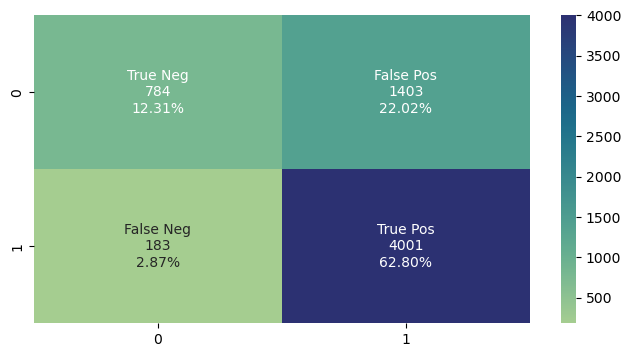

In [84]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_rfc.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_rfc.flatten()/np.sum(cf_matrix_rfc)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,4))
conf_mat = sns.heatmap(cf_matrix_rfc, annot=labels, fmt='', cmap='crest')

In [85]:
# Extracting the importances by sklearn 
importances_rfc = rfc.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_rfc = {}
for i, feature in enumerate(features):
    feature_importance_rfc[feature] = round(importances_rfc[i], 3)

print(f"Feature importance by sklearn: {feature_importance_rfc}")

Feature importance by sklearn: {'Area Speed': 0.033, 'Road Surface': 0.003, 'Moisture Cond': 0.009, 'Weather Cond': 0.007, 'DayNight': 0.012, 'DUI Involved': 0.004, 'Drugs Involved': 0.022, 'Veh Year': 0.074, 'Sex': 0.015, 'Age': 0.076, 'Unit Involved': 0.001, 'Hourly': 0.071, 'Day Group': 0.011, 'Distance To CC': 0.099, 'Stats Area_1 City': 0.003, 'Stats Area_2 Metropolitan': 0.007, 'Stats Area_3 Country': 0.005, 'Month_April': 0.007, 'Month_August': 0.008, 'Month_December': 0.009, 'Month_February': 0.009, 'Month_January': 0.008, 'Month_July': 0.007, 'Month_June': 0.007, 'Month_March': 0.009, 'Month_May': 0.008, 'Month_November': 0.009, 'Month_October': 0.009, 'Month_September': 0.008, 'Day_Friday': 0.013, 'Day_Monday': 0.012, 'Day_Saturday': 0.009, 'Day_Sunday': 0.008, 'Day_Thursday': 0.012, 'Day_Tuesday': 0.012, 'Day_Wednesday': 0.013, 'Position Type_Cross Road': 0.009, 'Position Type_Crossover': 0.0, 'Position Type_Divided Road': 0.009, 'Position Type_Freeway': 0.002, 'Position Typ

In [86]:
rfc_result = pd.DataFrame({'Feature':feature_importance_rfc.keys(),'Importance':feature_importance_rfc.values()})
rfc_result.set_index('Feature', inplace = True)
rfc_result.sort_values(by='Importance', ascending=False, key=abs)

,Importance
Feature,
Distance To CC,0.099
Age,0.076
Veh Year,0.074
Hourly,0.071
Area Speed,0.033
Drugs Involved,0.022
Sex,0.015
Day_Wednesday,0.013
Day_Friday,0.013


In [87]:
rfc_nonzero = rfc_result.loc[(rfc_result['Importance'] != 0) | (rfc_result['Importance'] != -0)]
rfc_nonzero = rfc_nonzero.sort_values(by='Importance', key=abs, ascending=False)
rfc_nonzeros = rfc_nonzero.head(20)
rfc_nonzeros 

,Importance
Feature,
Distance To CC,0.099
Age,0.076
Veh Year,0.074
Hourly,0.071
Area Speed,0.033
Drugs Involved,0.022
Sex,0.015
Day_Wednesday,0.013
Day_Friday,0.013


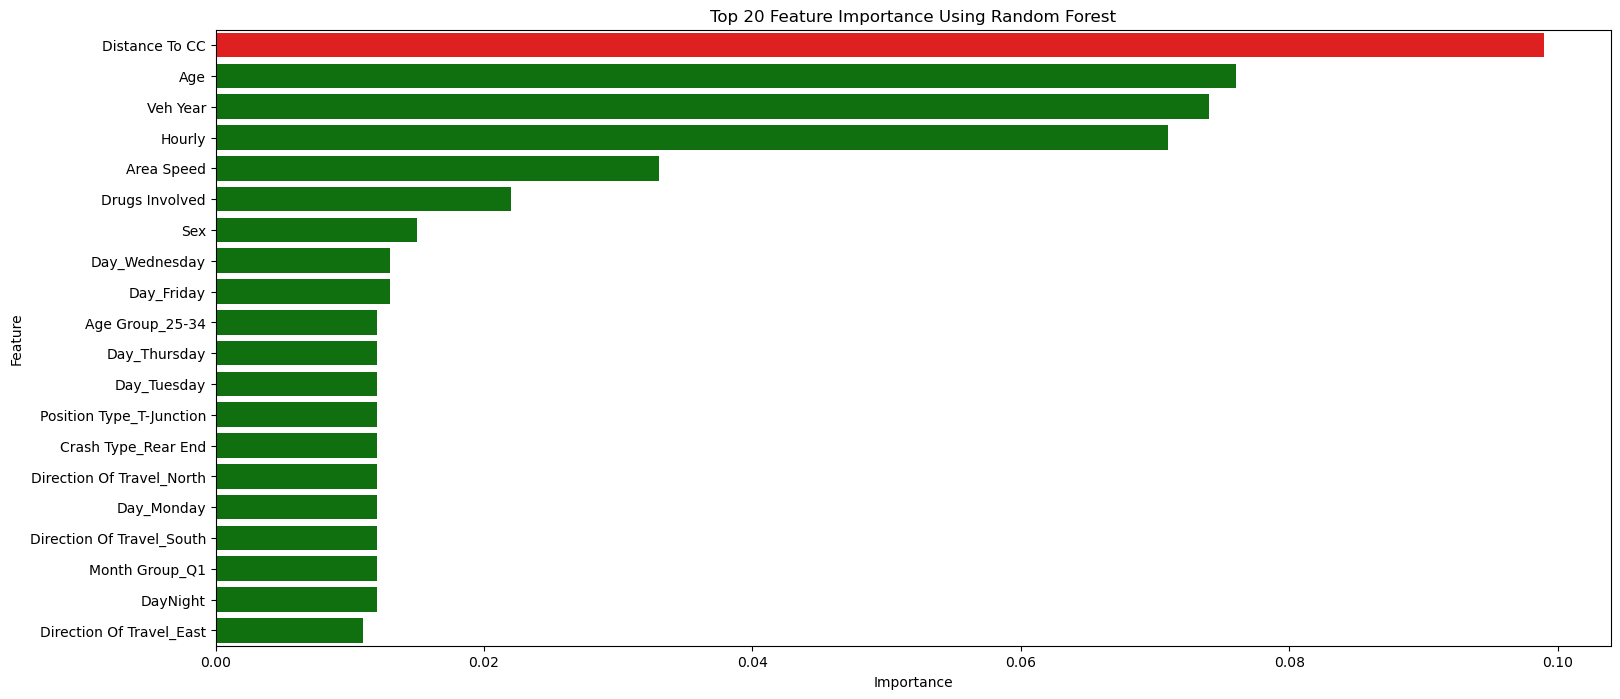

In [88]:
values = rfc_nonzeros['Importance']
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
plt.rcParams['figure.figsize'] = (18, 8)

feat_importance = sns.barplot(y=rfc_nonzeros.index, x=values, palette=clrs)
plt.title('Top 20 Feature Importance Using Random Forest')
plt.show()

In [96]:
df_rfc_top20 = rfc_nonzeros.reset_index()
df_rfc_top20

,Feature,Importance
0,Distance To CC,0.099
1,Age,0.076
2,Veh Year,0.074
3,Hourly,0.071
4,Area Speed,0.033
5,Drugs Involved,0.022
6,Sex,0.015
7,Day_Wednesday,0.013
8,Day_Friday,0.013
9,Age Group_25-34,0.012


In [97]:
df_rfc_top20.to_csv(os.path.join(path, '01. Data', 'Prepared data', 'random_forest_top20.csv'), sep = ',')

In [ ]:
conf_mat.figure.savefig(os.path.join(path, '04. Visualizations', 'conf_mat.png'))

In [ ]:
feat_importance.figure.savefig(os.path.join(path, '04. Visualizations', 'feature_inportance.png'))

In [ ]:
gc.collect()